In [ ]:
##########################################################複製區塊
# import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np

#setup some constants and parameters
M=2**21
tsim=7e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=50000
frq_min = 0
frq_max = 100/2/np.pi
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp=1
nfreq =  1000
#define the starting sum of the result
Efsum = np.zeros(nfreq)
Ens = np.zeros(2*22)
resolution = 1
sz = 4  
cell = mp.Vector3(0, 0, sz)
dpml = 1.0
pml_layers = [mp.PML(dpml)]
nq = 0


for i in range(Ncomp):
    
    def random_En(t):
        #generate random numbers
        M0 = np.random.normal(0,1)
        Mlp = np.random.normal(0,1,M-1)
        Nlp = np.random.normal(0,1,M-1)
        MM = np.random.normal(0,1)
    
        #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
        #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
        #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
        Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
        Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
        Eflm = np.flip(np.conjugate(Eflp))
        EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
        Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
        #we normalize Ef and compute its inverse fast fourier transform
        Efn = deltap*T/np.sqrt(tsim)*Ef
        En = np.fft.ifft(Efn)*M
        return En
    En0 = random_En(1)
    En1 = random_En(1)
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('m'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    def source0(t):
        f = int(t*2000)
        return En0[f]
    def source1(t):
        f = int(t*2000)
        return En1[f]

    sources = [mp.Source(mp.CustomSource(src_func=source0),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,-0.5*sz+dpml),
                     ),
              mp.Source(mp.CustomSource(src_func=source1),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,0.5*sz-dpml),
                     )
              ]
    
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions = 1,
                    Courant = 1,
                    resolution=resolution)
    

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,0))
    tran = sim.add_energy(fcen, df, nfreq, tran_fr)
    
    
    sim.run(until=2090)

    tran_flux = mp.get_magnetic_energy(tran)
    Ts = []
    for i in range(nfreq):
        Ts = np.append(Ts,tran_flux[i])    
    Efsum += Ts
    
    
    

#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it
######################################################複製區塊


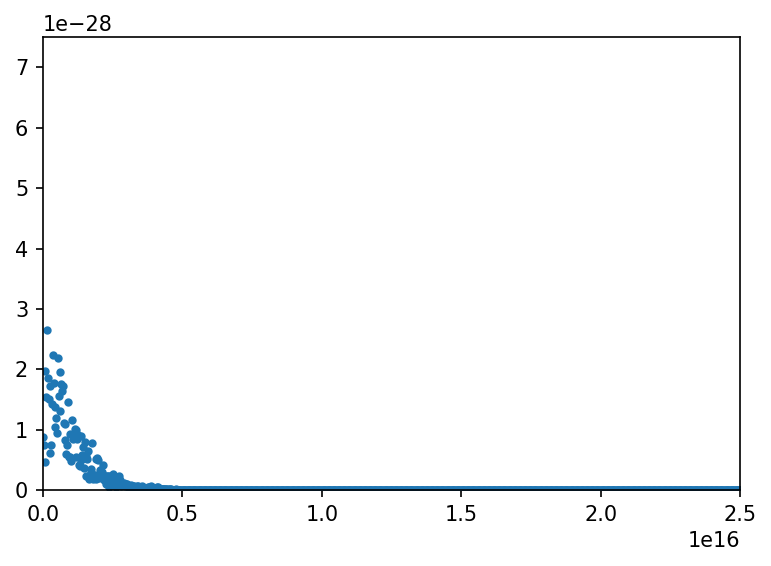

In [23]:
plt.figure(dpi=150)
freqs = np.linspace(0,30e15,1000)
plt.plot(freqs,Efavg*tsim*eps0*2*np.pi/2**21,'.')
plt.xlim(0,25e15)
plt.ylim(0,7.5e-28)
#plt.savefig('detector_vacuum_50000.png')
plt.show()

#np.savez("custom_source_vacuum_50000.npz", Efavg_50000 = Efavg)

Text(0, 0.5, 'Electric field source Es')

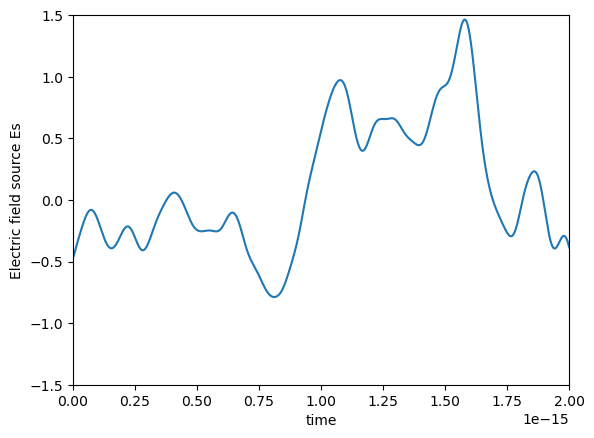

In [19]:
timess = np.linspace(0,7*1e-12,4194304)
plt.plot(timess,En1)
plt.xlim(0,2e-15)
plt.ylim(-1.5,1.5)
#plt.savefig('time_35.png')
np.savez("5.npz", Es = En1)
plt.xlabel('time')
plt.ylabel('Electric field source Es')

In [82]:
from PIL import Image

def transPNG(srcImageName, dstImageName):
    img = Image.open(srcImageName)
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = list()
    for item in datas:
        if item[0] > 225 and item[1] > 225 and item[2] > 225:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    img.save(dstImageName, "PNG")
transPNG('detector_vacuum_50000.png','trans_detector_vacuum_50000.png')